/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Value iteration converged after 5 iterations.


../utils/helper_functions_multitask.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
../utils/helper_functions.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/quiver.py:668: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rc

goal_reached 1
goal_reached 1
goal_reached 2
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 4
goal_reached 2
goal_reached 1
goal_reached 1
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 4


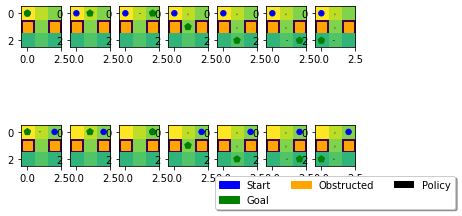

In [1]:
import sys
sys.path.append("..")
import numpy as np
from env.grid_world_multitask import GridWorld
from algorithms.dynamic_programming_multitask import value_iteration
from utils.plots_multitask import plot_gridworld, plot_gridworld_subtasks
import copy

###########################################################
#          Run value iteration on a grid world            #
###########################################################

# specify world parameters
num_cols = 3
num_rows = 3
obstructions = np.array([[1,0],[1,2]])
start_state = np.array([[0,0], [0,2]])
start_states_plot = start_state
# start_states_plot = np.array([[0,0], [0,2]])
# goal_states_plot = np.array([[2,2], [2, 2]])
# start_states_plot = np.array([[0,0]], )
# goal_states_plot = np.array([[2,2]])
# goal_states = np.array([[2, 0], [2, 1]])
goal_states = np.array([[0,0], [0,1], [0,2], [1, 1], [2, 1], [2,2], [2, 0]])
goal_states_plot = goal_states

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states)
gw.add_obstructions(
                    obstructed_states=obstructions,
                    # bad_states=bad_states,
                    # restart_states=restart_states
                    )
gw.add_rewards(
               step_reward=0,
               goal_reward=1,
               bad_state_reward=0,
               restart_state_reward=0)
gw.add_transition_probability(p_good_transition=1.,
                              bias=0.)
gw.add_discount(discount=0.9)
model = gw.create_gridworld()

# print('model created')

# solve with value iteration
value_function, policy = value_iteration(model, maxiter=100)

# print('policy created')

# print('policy', policy.shape)

# plot the results
path = "../doc/imgs/value_iteration.png"
plot_gridworld(model, value_function=value_function, policy=policy,
               # title="Value iteration",
               path=path,
               start_states=start_states_plot, goal_states=goal_states_plot)

# print('plot saved')

(2, 2) (2, 2) (2, 1, 2)
subgoal_states [[0 2]]
goal_reached 2
goal_reached 4
subgoal_states [[1 1]]
goal_reached 2
goal_reached 2


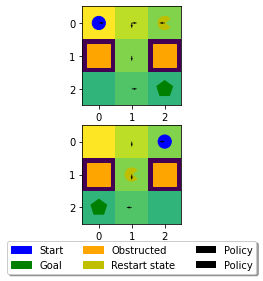

In [2]:
start_state_sub = np.array([[0,0], [0,2]])
goal_states_sub = np.array([[2,2], [2, 0]])
subgoal_states_sub = np.array([[[0,2]], [[1, 1]]])
print(start_state_sub.shape, goal_states_sub.shape, subgoal_states_sub.shape)
plot_gridworld_subtasks(model, value_function=value_function, policy=policy, path=path,
                       start_states=start_state_sub, goal_states=goal_states_sub, subgoal_states=subgoal_states_sub)

In [3]:
value_function = value_function[:, :, 0]

In [4]:
value_function.shape

(10, 10)

In [5]:
from utils.helper_functions import row_col_to_seq, seq_to_col_row

In [6]:
X = []
index = []
for state_seq in range(model.num_states-1):
    for goal in goal_states:
        goal = goal[None, :]
        state = seq_to_col_row(state_seq, model.num_cols)
        goal_seq = row_col_to_seq(goal, model.num_cols)
        x = np.hstack([state, goal])
        X.append(x)
        index.append([state_seq, goal_seq[0]])
X = np.array(X)[:, 0]
index = np.array(index)

y = value_function[index[:, 0], index[:, 1]]

X.shape, y.shapez

((63, 4), (63,))

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
reg = LinearRegression().fit(X, y)

In [9]:
y_hat = reg.predict(X)

In [10]:
((y_hat-y)**2).mean()

0.1257569123708743

In [11]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))

    # plot the results
    path = "../doc/imgs/value_iteration.png"
    plot_gridworld(model, value_function=val_hat_, policy=pi_hat,
                   # title="Value iteration",
                   path=path,
                   start_states=start_states_plot, goal_states=goal_states_plot)

../utils/helper_functions_multitask.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
../utils/helper_functions.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/quiver.py:668: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rc

goal_reached 1
goal_reached 1


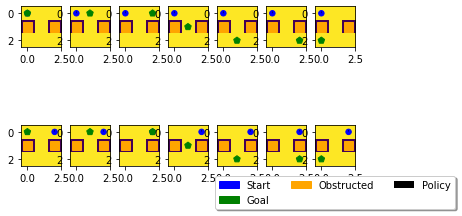

In [12]:
find_plot_pi_hat(y_hat, model, index)

## Simple One-hidden-layer MLP

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

In [14]:
class ValueDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y, scale_data=True):
        # Apply scaling if necessary
        if scale_data:
            X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [15]:
# Prepare dataset
dataset = ValueDataset(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=70, shuffle=True, num_workers=0)

In [16]:
class MLP(nn.Module):
    def __init__(self, middle_dim=4):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(4, middle_dim),
              nn.LeakyReLU(),
              nn.Linear(middle_dim, 1),
#               nn.LeakyReLU(),
#               nn.Linear(64, 1)
        )


    def forward(self, x):
        return self.layers(x)

In [17]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-2)

In [18]:
# Run the training loop
for epoch in range(0, 5000): # 5 epochs at maximum
    # Print epoch
#     print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    if epoch % 500 == 0:
        print('Loss: %.3f' % (current_loss ))
    current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Loss: 0.800
Loss: 0.252
Loss: 0.240
Loss: 0.195
Loss: 0.183
Loss: 0.170
Loss: 0.157
Loss: 0.145
Loss: 0.133
Loss: 0.123
Training process has finished.


In [19]:
predict = mlp(torch.tensor(StandardScaler().fit_transform(X)).float())[:, 0].detach().numpy()
((y - predict)**2).mean()


0.05243444691922949

../utils/helper_functions_multitask.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
../utils/helper_functions.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/quiver.py:668: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rc

goal_reached 1
goal_reached 1
goal_reached 1
goal_reached 1


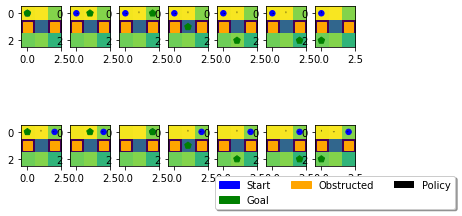

In [20]:
find_plot_pi_hat(predict, model, index)

goal_reached 1
goal_reached 1
goal_reached 2
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 4
goal_reached 2
goal_reached 1
goal_reached 1
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 4


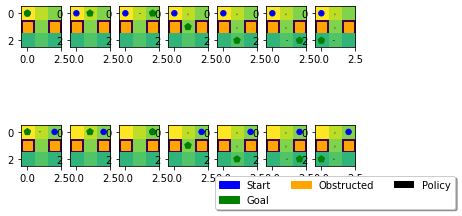

In [21]:
find_plot_pi_hat(y, model, index)

# Devide and Conquer  2

# Devide

In [22]:
mean, std = 0., 1.
# mean=np.mean(X), std=np.std(X)

In [23]:
# specify world parameters
num_cols = 3
num_rows = 3
obstructions = np.array([[1,0],[1,2]])
start_state = np.array([[0,0], [0,2]])
start_states_plot = start_state
# start_states_plot = np.array([[0,0], [0,2]])
# goal_states_plot = np.array([[2,2], [2, 2]])
# start_states_plot = np.array([[0,0]], )
# goal_states_plot = np.array([[2,2]])
# goal_states = np.array([[2, 0], [2, 1]])
goal_states = np.array([[0,0], [0,1], [0,2], [1, 1], [2, 1], [2,2], [2, 0]])
goal_states_plot = goal_states

In [24]:
class ValueDataset(torch.utils.data.Dataset):
    def __init__(self, value_function, start_states, goal_states, model, mean=None, std=None):
        self.value_function = value_function
        self.start_states = start_states
        self.goal_states = goal_states
        self.start_states_seq = row_col_to_seq(self.start_states, model.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, model.num_cols)
        self.start_states = (self.start_states - mean) / std
        self.goal_states = (self.goal_states - mean) / std
        self.start_dict = {k: v for k, v in zip(self.start_states_seq, self.start_states)}
        self.goal_dict = {k: v for k, v in zip(self.goal_states_seq, self.goal_states)}
        
    def __len__(self):
        return len(self.start_states_seq)*len(self.goal_states_seq)

    def __getitem__(self, idx):
        s_idx = idx % len(self.goal_states_seq) #start index
        g_idx = idx // len(self.goal_states_seq) #goal index
        s = self.start_states_seq[s_idx]
        g = self.goal_states_seq[g_idx]
        if s==g:
            g = self.goal_states_seq[np.random.randint(len(self.goal_states_seq)) % len(self.goal_states_seq)]
        v_x = self.value_function[s, g]
        x = np.hstack([self.start_dict[s], self.goal_dict[g]])
        xsm = []
        xmg = []
        v_xsm = []
        v_xmg = []
        for m in self.start_states_seq:
            xsm.append(np.hstack([self.start_dict[s], self.goal_dict[m]]))
            xmg.append(np.hstack([self.start_dict[m], self.goal_dict[g]]))
            v_xsm.append(self.value_function[s, m])
            v_xmg.append(self.value_function[m, g])

        xsm = np.array(xsm)
        xmg = np.array(xmg)
        v_xsm = np.array(v_xsm)
        v_xmg = np.array(v_xmg)
        return x, xsm, xmg, v_x, v_xsm, v_xmg 

In [25]:
# Prepare dataset
dataset = ValueDataset(value_function,
                       start_states=goal_states, goal_states=goal_states,
                       model=model, 
                       mean=mean, std=std
                      )
trainloader = torch.utils.data.DataLoader(dataset, batch_size=70, shuffle=False, num_workers=0)

In [26]:
class DC(nn.Module):
    def __init__(self, middle_dim=16, n_states=7, states=None, mean=0, std=1):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(4, middle_dim),
              nn.LeakyReLU(),
              nn.Linear(middle_dim, 1),
#               nn.LeakyReLU(),
#               nn.Linear(64, 1)
        )
        
        self.proba = nn.Sequential(
            nn.Linear(4, 32),
            nn.LeakyReLU(),
            nn.Linear(32, n_states+1),
#             nn.LeakyReLU(),
#             nn.Linear(128, n_states+1),
            nn.Softmax()
        )
        
        self.states_original = states
        self.mean = mean
        self.std = std
        self.states = (self.states_original - mean) / std
        
    def prepare_data(self, s, g):
        x = np.hstack([s, g])
        x_s_m = []
        x_m_g = []
        for m in self.states:
            xsm = np.hstack([s, m])
            xmg = np.hstack([m, g])
            x_s_m.append(xsm)
            x_m_g.append(xmg)
        
        x_s_m = np.array(x_s_m)
        x_m_g = np.array(x_m_g)
        
        data = torch.tensor(x[None]).float(), torch.tensor(x_s_m[None]).float(), torch.tensor(x_m_g[None]).float()
        
        return data
        

    def forward(self, data):
        x, x_s_m, x_m_g = data
        p = self.proba(x)
        y_x = self.layers(x)
        y_xsm = self.layers(x_s_m)
        y_xmg = self.layers(x_m_g)
        subpaths = y_xsm[:, :, 0]*y_xmg[:, :, 0]
        paths = torch.cat([y_x, subpaths], 1)
        return p, paths, y_x, y_xsm, y_xmg


In [27]:
# Initialize the MLP
mlp = DC(states=goal_states, 
         mean=mean, std=std
        )

# Define the loss function and optimizer
# loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3)

In [28]:
# Run the training loop
for epoch in range(0, 10000): # 5 epochs at maximum
    # Print epoch
#     print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        x, x_s_m, x_m_g, v_x, v_xsm, v_xmg  = data
        
        x, x_s_m, x_m_g, v_x, v_xsm, v_xmg  = x.float(), x_s_m.float(), x_m_g.float(), v_x.float(), v_xsm.float(), v_xmg.float()
        inputs = x, x_s_m, x_m_g
        v_x, v_xsm, v_xmg = v_x.unsqueeze(-1), v_xsm.unsqueeze(-1), v_xmg.unsqueeze(-1)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        p, outputs, y_x, y_xsm, y_xmg = mlp(inputs)

        # Compute loss
        loss_v_x = (p[:, :1]*torch.abs(y_x-v_x)).sum(dim=1).mean()
        coef = 1
        loss_v_xsm = coef*(p[:, 1:].unsqueeze(-1)*torch.abs((y_xsm-v_xsm)*v_xmg)).sum(dim=1).mean()
        loss_v_xmg = coef*(p[:, 1:].unsqueeze(-1)*torch.abs((y_xmg-v_xmg)*v_xsm)).sum(dim=1).mean()
        loss_vsg_vsmg = 10*(p[:, 1:].unsqueeze(-1)*torch.abs(v_xsm*v_xmg-v_x.unsqueeze(-1))).sum(dim=1).mean()
        loss = loss_v_x + loss_v_xsm + loss_v_xmg + loss_vsg_vsmg
#         loss = loss_vsg_vsmg + (p[:, :1]*100).mean()
#         loss = loss_vsg_vsmg + (p[:, :1]*100).mean() + loss_v_xsm + loss_v_xmg

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    if epoch % 500 == 0:
        print('Loss: %.3f' % (current_loss ))
        true_dif = (v_xsm*v_xmg)[:, :, 0]-v_x
        argmax = p[:, 1:].argmax(-1)
        print('p argrmax', p.argmax(-1))
        print('p argrmax 1:', argmax)
#         seq_to_col_row()
#         abs_argmax = torch.abs(outputs.detach()-v_x).argmax(-1)
#         print('argmax abs', abs_argmax)
#         abs_argmax = torch.abs(outputs[:, 1:].detach()-v_x).argmax(-1)
        print('true_dif[:, abs_argmax]', true_dif[torch.arange(len(argmax)), argmax])
        
    current_loss = 0.0

# Process is complete.
print('Training process has finished.')

/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 2.682
p argrmax tensor([2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0,
        2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 7, 2, 2, 2, 0, 0,
        0])
p argrmax 1: tensor([1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1,
        2])
true_dif[:, abs_argmax] tensor([ 0.0000e+00,  0.0000e+00, -5.9605e-08, -1.5390e-01, -1.3851e-01,
        -1.2466e-01, -1.2466e-01, -1.7100e-01,  0.0000e+00,  0.0000e+00,
        -1.7100e-01, -1.5390e-01, -1.3851e-01, -1.3851e-01, -5.9605e-08,
         0.0000e+00,  0.0000e+00, -5.9605e-08,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -5.9605e-08,  0.0000e+00, -5.9605e-08, -1.5390e-01,
        -1.7100e-01, -1.5390e-01, -2.7856e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -1.7100e-01,  0.0000e+00, -3.0951e-01, -3.0951e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5390e-01, -3.0951e-01,
        -4.68

Loss: 0.107
p argrmax tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
p argrmax 1: tensor([1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1,
        4])
true_dif[:, abs_argmax] tensor([ 0.0000e+00,  0.0000e+00, -5.9605e-08, -5.9605e-08,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.9605e-08,
         0.0000e+00,  0.0000e+00, -5.9605e-08,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -5.9605e-08,  0.0000e+00, -5.9605e-08, -1.5390e-01,
        -1.7100e-01, -1.5390e-01, -1.5390e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -1.7100e-01,  0.0000e+00, -3.0951e-01, -3.0951e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5390e-01, -3.0951e-01,
        -4.68

Loss: 0.037
p argrmax tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
p argrmax 1: tensor([1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])
true_dif[:, abs_argmax] tensor([-5.9605e-08,  0.0000e+00, -5.9605e-08, -5.9605e-08,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.9605e-08,
         0.0000e+00,  0.0000e+00, -5.9605e-08,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -5.9605e-08,  0.0000e+00, -5.9605e-08, -5.9605e-08,
        -1.7100e-01, -1.5390e-01, -1.5390e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -1.7100e-01, -3.4390e-01, -3.0951e-01, -3.0951e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5390e-01, -3.0951e-01,
        -3.09

In [29]:
predict = []
for x in X:
    x = (x - mean) / std
    s = x[:2]
    g = x[2:]
    data = mlp.prepare_data(s, g)
    p, v, y_x, y_xsm, y_xmg = mlp(data)
#     print('p', p)
    idx = p.argmax()
#     print('idx', idx)
#     print('m', mlp.states_original[idx-1:idx])
#     print(mlp.get_propa(data))
    predict.append(v.detach().numpy()[:, 0])

predict = np.array(predict)[:, 0]
    
    

In [30]:
start_state_sub = np.array([[0,0], [0,2], [2,2], [2, 0], [0,0], [0,2], [2,2], [2, 0], [0,0]])
goal_states_sub = np.array([[2,2], [2, 0], [0,0], [0,2], [0,2], [0,0], [2, 0], [2,2], [0,1]])
subgoal_states_sub = []

for s, g in zip(start_state_sub, goal_states_sub):
    s = (s - mean) / std
    g = (g - mean) / std
    data = mlp.prepare_data(s, g)
    p, *_ = mlp(data)
    idx = p.argmax()
    print('idx', idx)
    if idx == 0:
        subgoal_states_sub.append([None])
    else:
        subgoal_states_sub.append(mlp.states_original[idx-1:idx])
        
print(start_state_sub.shape, goal_states_sub.shape, len(subgoal_states_sub))


idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
(9, 2) (9, 2) 9


In [31]:
subgoal_states_sub

[[None], [None], [None], [None], [None], [None], [None], [None], [None]]

In [32]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,20)

In [33]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))
    
    return pi_hat

subgoal_states [None]


TypeError: list indices must be integers or slices, not tuple

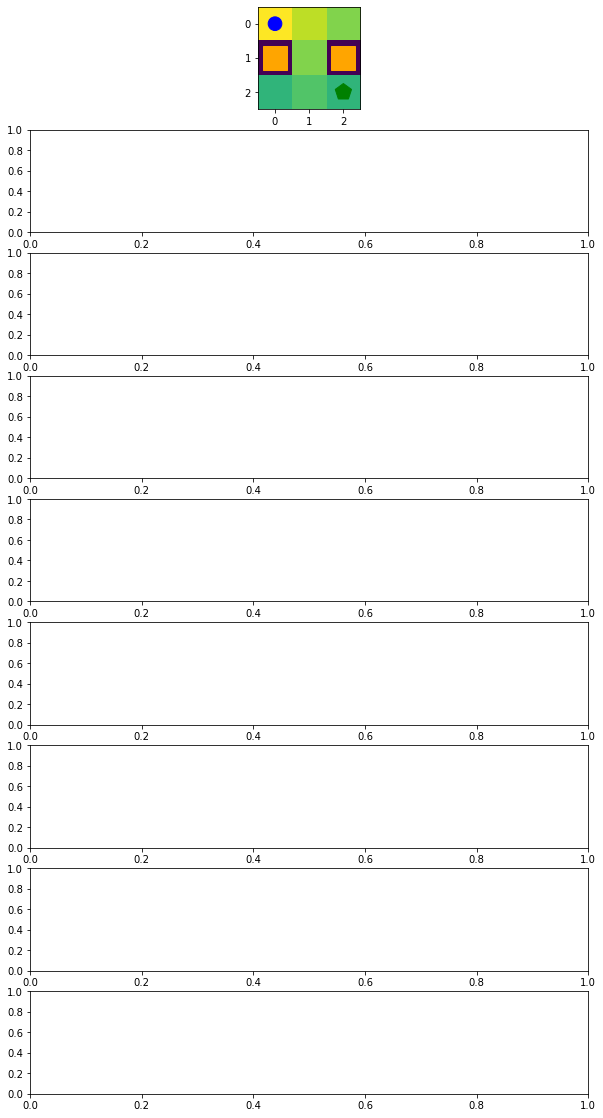

In [34]:
pi_hat = find_plot_pi_hat(predict, model, index)
plot_gridworld_subtasks(model, value_function=value_function, policy=pi_hat, path=path,
                       start_states=start_state_sub, goal_states=goal_states_sub, subgoal_states=subgoal_states_sub)